# A. Importing necessary libraries 

In [1]:
import os
import json
import torch
import string
import gensim
import gensim.downloader
from gensim.models import Word2Vec
import pandas as pd
from d2l import torch as d2l
from torch import nn
from collections import Counter
from imblearn.over_sampling import SMOTE
from tf_keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

2024-03-31 19:20:22.700419: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# B. Data preprocessing

## B1. Reading the json file

In [2]:
#Reading the json file
file_path = '/Users/admin/Library/CloudStorage/OneDrive-AshesiUniversity/Ashesi University/ashesi_year_4/machine_learning/d2l-en/pytorch/Final_Project/train.json.zip'
df = pd.read_json(file_path)
df

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."
...,...,...,...,...,...
6802,22678,EXAMPLE – JOURNEY MAP\n\nTHE CHALLENGE My w...,"[EXAMPLE, –, JOURNEY, MAP, \n\n, THE, CHALLENG...","[True, True, True, False, False, True, True, F...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6803,22679,Why Mind Mapping?\n\nMind maps are graphical r...,"[Why, Mind, Mapping, ?, \n\n, Mind, maps, are,...","[True, True, False, False, False, True, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6804,22681,"Challenge\n\nSo, a few months back, I had chos...","[Challenge, \n\n, So, ,, a, few, months, back,...","[False, False, False, True, True, True, True, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6805,22684,Brainstorming\n\nChallenge & Selection\n\nBrai...,"[Brainstorming, \n\n, Challenge, &, Selection,...","[False, False, True, True, False, False, True,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [3]:
# get relevant columns
# clean full_text and remove extra characters 
# create word index
# encode bio labels
# explode data to get tokens

## B2. Extracting relevant columns

In [4]:
data = df[['document', 'tokens', 'labels']]
data['tokens'][0]
len(data['tokens'][0])

753

## B3. Cleaning tokens columns in data set

In [5]:
def preprocess(tokens):
    lowercase_tokens = [token.lower() for token in tokens]
    return lowercase_tokens

In [6]:
data['processed_tokens'] = data['tokens'].apply(preprocess)
data = data[['document', 'processed_tokens', 'labels']]
data

/var/folders/h3/ngfp429s6d3d3kvbxfb1q9pm0000gn/T/ipykernel_37448/1502291209.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['processed_tokens'] = data['tokens'].apply(preprocess)


,document,processed_tokens,labels
0,7,"[design, thinking, for, innovation, reflexion,...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,"[diego, estrada, \n\n, design, thinking, assig...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,"[reporting, process, \n\n, by, gilberto, gambo...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,"[design, thinking, for, innovation, \n\n, sind...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,"[assignment, :, , visualization, , reflecti...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."
...,...,...,...
6802,22678,"[example, –, journey, map, \n\n, the, challeng...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6803,22679,"[why, mind, mapping, ?, \n\n, mind, maps, are,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6804,22681,"[challenge, \n\n, so, ,, a, few, months, back,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6805,22684,"[brainstorming, \n\n, challenge, &, selection,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


## B4. Creating word index for processed_tokens examples in data

In [7]:
tokens = data['processed_tokens']

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokens)
word_index = tokenizer.word_index
word_index

{'the': 1,
 ' ': 2,
 '.': 3,
 'to': 4,
 ',': 5,
 'and': 6,
 'of': 7,
 '\n\n': 8,
 'a': 9,
 'in': 10,
 'i': 11,
 'we': 12,
 'that': 13,
 'for': 14,
 'is': 15,
 'with': 16,
 'it': 17,
 'this': 18,
 'was': 19,
 'as': 20,
 'our': 21,
 'on': 22,
 'be': 23,
 'their': 24,
 '\t\r \xa0': 25,
 '-': 26,
 'they': 27,
 'have': 28,
 'my': 29,
 'tool': 30,
 'are': 31,
 'from': 32,
 'what': 33,
 'were': 34,
 'them': 35,
 'not': 36,
 'by': 37,
 'or': 38,
 'an': 39,
 'can': 40,
 ':': 41,
 'more': 42,
 '\xa0': 43,
 'team': 44,
 'design': 45,
 'all': 46,
 ')': 47,
 'would': 48,
 'will': 49,
 'which': 50,
 'challenge': 51,
 'process': 52,
 'how': 53,
 'also': 54,
 'about': 55,
 'time': 56,
 'mind': 57,
 '(': 58,
 'had': 59,
 'people': 60,
 'learning': 61,
 'at': 62,
 'approach': 63,
 'one': 64,
 'use': 65,
 'new': 66,
 'so': 67,
 'thinking': 68,
 'but': 69,
 'different': 70,
 'visualization': 71,
 'you': 72,
 'work': 73,
 'us': 74,
 'launch': 75,
 'problem': 76,
 'ideas': 77,
 'could': 78,
 'each': 79,
 'a

In [9]:
len(word_index)

44390

## B5. Placing encoded tokens in data

In [10]:
encoded_tokens = tokenizer.texts_to_sequences(tokens)

In [11]:
data['encoded_tokens'] = encoded_tokens
data = data[['document', 'processed_tokens', 'encoded_tokens', 'labels']]
data

,document,processed_tokens,encoded_tokens,labels
0,7,"[design, thinking, for, innovation, reflexion,...","[45, 68, 14, 271, 8702, 26, 16418, 3564, 26, 1...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,"[diego, estrada, \n\n, design, thinking, assig...","[11538, 16424, 8, 45, 68, 624, 8, 71, 30, 8, 5...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,"[reporting, process, \n\n, by, gilberto, gambo...","[1723, 52, 8, 37, 24720, 24721, 8, 51, 8, 11, ...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,"[design, thinking, for, innovation, \n\n, sind...","[45, 68, 14, 271, 8, 24722, 24723, 8, 19273, 6...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,"[assignment, :, , visualization, , reflecti...","[624, 41, 251, 71, 43, 205, 251, 2360, 43, 37,...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."
...,...,...,...,...
6802,22678,"[example, –, journey, map, \n\n, the, challeng...","[257, 126, 304, 188, 8, 1, 51, 109, 29, 3938, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6803,22679,"[why, mind, mapping, ?, \n\n, mind, maps, are,...","[247, 57, 84, 135, 8, 57, 515, 31, 1875, 3198,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6804,22681,"[challenge, \n\n, so, ,, a, few, months, back,...","[51, 8, 67, 5, 9, 311, 595, 354, 5, 11, 59, 99...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6805,22684,"[brainstorming, \n\n, challenge, &, selection,...","[510, 8, 51, 134, 115, 8, 510, 15, 9, 113, 678...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


## B6. Exploding tokens and labels

In [12]:
len(data['encoded_tokens'][0])

753

In [13]:
len(data['labels'][0])

753

In [14]:
data = data.explode(['encoded_tokens', 'labels'])
print(data['encoded_tokens'].dtype)
data

object


,document,processed_tokens,encoded_tokens,labels
0,7,"[design, thinking, for, innovation, reflexion,...",45,O
0,7,"[design, thinking, for, innovation, reflexion,...",68,O
0,7,"[design, thinking, for, innovation, reflexion,...",14,O
0,7,"[design, thinking, for, innovation, reflexion,...",271,O
0,7,"[design, thinking, for, innovation, reflexion,...",8702,O
...,...,...,...,...
6806,22687,"[mind, mapping, \n\n, challenge, \n\n, my, con...",52,O
6806,22687,"[mind, mapping, \n\n, challenge, \n\n, my, con...",836,O
6806,22687,"[mind, mapping, \n\n, challenge, \n\n, my, con...",642,O
6806,22687,"[mind, mapping, \n\n, challenge, \n\n, my, con...",3,O


In [15]:
data['encoded_tokens'] = data['encoded_tokens'].astype(int)
print(data['encoded_tokens'].dtype)
data

int64


,document,processed_tokens,encoded_tokens,labels
0,7,"[design, thinking, for, innovation, reflexion,...",45,O
0,7,"[design, thinking, for, innovation, reflexion,...",68,O
0,7,"[design, thinking, for, innovation, reflexion,...",14,O
0,7,"[design, thinking, for, innovation, reflexion,...",271,O
0,7,"[design, thinking, for, innovation, reflexion,...",8702,O
...,...,...,...,...
6806,22687,"[mind, mapping, \n\n, challenge, \n\n, my, con...",52,O
6806,22687,"[mind, mapping, \n\n, challenge, \n\n, my, con...",836,O
6806,22687,"[mind, mapping, \n\n, challenge, \n\n, my, con...",642,O
6806,22687,"[mind, mapping, \n\n, challenge, \n\n, my, con...",3,O


## B7. Balancing data using undersampling then smote oversampling

### B7. a. Undersampling the data

In [16]:
# Calculate the number of samples in each class
class_counts = Counter(data['labels'])
class_counts

Counter({'O': 4989794,
         'B-NAME_STUDENT': 1365,
         'I-NAME_STUDENT': 1096,
         'B-URL_PERSONAL': 110,
         'B-ID_NUM': 78,
         'B-EMAIL': 39,
         'I-STREET_ADDRESS': 20,
         'I-PHONE_NUM': 15,
         'B-USERNAME': 6,
         'B-PHONE_NUM': 6,
         'B-STREET_ADDRESS': 2,
         'I-URL_PERSONAL': 1,
         'I-ID_NUM': 1})

In [17]:
# Determine the majority and minority classes
majority_class = max(class_counts, key=class_counts.get)
minority_classes = [label for label in class_counts.keys() if label != majority_class]
majority_class, minority_classes

('O',
 ['B-NAME_STUDENT',
  'I-NAME_STUDENT',
  'B-URL_PERSONAL',
  'B-EMAIL',
  'B-ID_NUM',
  'I-URL_PERSONAL',
  'B-USERNAME',
  'B-PHONE_NUM',
  'I-PHONE_NUM',
  'B-STREET_ADDRESS',
  'I-STREET_ADDRESS',
  'I-ID_NUM'])

In [18]:
# Calculate undersampling proportion
total_minority_samples = sum(class_counts[label] for label in minority_classes)
undersampling_proportion = total_minority_samples / class_counts[majority_class]
total_minority_samples, undersampling_proportion

(2739, 0.0005489204564356765)

In [19]:
# Determine number of samples to retain from the majority class
num_samples_to_retain = int(undersampling_proportion * class_counts[majority_class])
num_samples_to_retain

2739

In [20]:
# Undersample the majority class
undersampled_majority = data[data['labels'] == majority_class].sample(n=num_samples_to_retain, random_state=42)
undersampled_majority

,document,processed_tokens,encoded_tokens,labels
3744,15653,"[1, ., challenge, :, describe, your, challenge...",46,O
4372,17194,"[design, thinking, assignment, \n\n, challenge...",17,O
1878,11427,"[reflection, –, learning, launch, \n\n, challe...",1561,O
2018,11705,"[wing, tank, pressure, test, -, learning, laun...",7,O
1020,9682,"[1, ., the, challenge, ., \n\n, the, problem, ...",1870,O
...,...,...,...,...
5063,18866,"[reflection, –, storytelling, \n\n, challenge,...",45,O
5116,19016,"[reflection, –, visualization, \n\n, challenge...",188,O
1155,9977,"[reflection, assignment, :, storytelling, for,...",329,O
1240,10147,"[design, thinking, for, innovation, \n\n, tool...",5,O


In [21]:
# Combine with minority classes
balanced_data = pd.concat([undersampled_majority] + [data[data['labels'] == label] for label in minority_classes])

# Shuffle the dataframe to mix the samples
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_data

,document,processed_tokens,encoded_tokens,labels
0,5606,"[project, :, spectacles, \n\n, interviewer, na...",11744,B-NAME_STUDENT
1,12859,"[reflection, –, story, telling, \n\n, mary, to...",19453,I-NAME_STUDENT
2,14348,"[challenge, \n\n, as, part, of, a, small, bout...",23,O
3,6121,"[thai, tamang, \n\n, reflection, -, learning, ...",26422,I-NAME_STUDENT
4,22659,"[peer, graded, assignment, :, reflection, \n\n...",1173,O
...,...,...,...,...
5473,10724,"[ankit, paul, , learning, launch, exercise,...",16610,B-NAME_STUDENT
5474,13299,"[using, visualization, to, create, lessons, ab...",9434,I-NAME_STUDENT
5475,6426,"[reflection, –, learning, launch, , challen...",26501,B-URL_PERSONAL
5476,6849,"[design, thinking, and, product, innovation, \...",26909,B-ID_NUM


In [22]:
# Calculate the number of samples in each class of the balanced dataset
class_counts = Counter(balanced_data['labels'])
class_counts

Counter({'O': 2739,
         'B-NAME_STUDENT': 1365,
         'I-NAME_STUDENT': 1096,
         'B-URL_PERSONAL': 110,
         'B-ID_NUM': 78,
         'B-EMAIL': 39,
         'I-STREET_ADDRESS': 20,
         'I-PHONE_NUM': 15,
         'B-PHONE_NUM': 6,
         'B-USERNAME': 6,
         'B-STREET_ADDRESS': 2,
         'I-ID_NUM': 1,
         'I-URL_PERSONAL': 1})

### B7. b. Smote Oversampling the data

In [23]:
# define new minority classes
minority_classes = ['B-URL_PERSONAL','B-ID_NUM','B-EMAIL','I-STREET_ADDRESS','I-PHONE_NUM','B-PHONE_NUM','B-USERNAME','B-STREET_ADDRESS']
# minority_classes = ['B-URL_PERSONAL','B-ID_NUM','B-EMAIL','I-STREET_ADDRESS','I-PHONE_NUM','B-PHONE_NUM','B-USERNAME']


In [24]:
# Define the SMOTE sampling strategy
smote_strategy = {label: 500 for label in minority_classes}

In [25]:
# Apply SMOTE oversampling
smote = SMOTE(sampling_strategy=smote_strategy, random_state=42, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(balanced_data['encoded_tokens'].values.reshape(-1, 1), balanced_data['labels'])

In [26]:
# Create a new DataFrame with resampled data
resampled_data = pd.DataFrame({'encoded_tokens': X_resampled.flatten(), 'labels': y_resampled})
resampled_data

,encoded_tokens,labels
0,11744,B-NAME_STUDENT
1,19453,I-NAME_STUDENT
2,23,O
3,26422,I-NAME_STUDENT
4,1173,O
...,...,...
9197,5757,I-STREET_ADDRESS
9198,29111,I-STREET_ADDRESS
9199,11964,I-STREET_ADDRESS
9200,21022,I-STREET_ADDRESS


In [27]:
# Concatenate resampled data with original DataFrame
balanced_data = pd.concat([balanced_data, resampled_data])

# Shuffle the DataFrame to mix the samples
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_data

,document,processed_tokens,encoded_tokens,labels
0,NaN,NaN,38106,O
1,NaN,NaN,16073,B-URL_PERSONAL
2,NaN,NaN,41,O
3,4061.0,"[design, thinking, for, innovation, course, re...",25556,B-NAME_STUDENT
4,11883.0,"[title, [, example, :, a, paper, on, security,...",6559,I-NAME_STUDENT
...,...,...,...,...
14675,9578.0,"[bussiness, proyect, \n\n, visualization, \n\n...",76,O
14676,NaN,NaN,26016,B-USERNAME
14677,15680.0,"[visualization, is, everything, \n\n, challeng...",13,O
14678,3885.0,"[1, leonardo, torres, \n\n, reflection, –, lea...",12408,B-NAME_STUDENT


In [28]:
# Calculate the number of samples in each class of the balanced dataset
class_counts = Counter(balanced_data['labels'])
class_counts

Counter({'O': 5478,
         'B-NAME_STUDENT': 2730,
         'I-NAME_STUDENT': 2192,
         'B-URL_PERSONAL': 610,
         'B-ID_NUM': 578,
         'B-EMAIL': 539,
         'I-STREET_ADDRESS': 520,
         'I-PHONE_NUM': 515,
         'B-PHONE_NUM': 506,
         'B-USERNAME': 506,
         'B-STREET_ADDRESS': 502,
         'I-URL_PERSONAL': 2,
         'I-ID_NUM': 2})

## B8. Encoding BIO format labels

In [29]:
encoded_labels = pd.get_dummies(balanced_data['labels'])
encoded_labels 

,B-EMAIL,B-ID_NUM,B-NAME_STUDENT,B-PHONE_NUM,B-STREET_ADDRESS,B-URL_PERSONAL,B-USERNAME,I-ID_NUM,I-NAME_STUDENT,I-PHONE_NUM,I-STREET_ADDRESS,I-URL_PERSONAL,O
0,False,False,False,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,True,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,True
3,False,False,True,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14675,False,False,False,False,False,False,False,False,False,False,False,False,True
14676,False,False,False,False,False,False,True,False,False,False,False,False,False
14677,False,False,False,False,False,False,False,False,False,False,False,False,True
14678,False,False,True,False,False,False,False,False,False,False,False,False,False


In [30]:
encoded_labels_tensor = torch.tensor(encoded_labels.values, dtype=torch.int64)
categories = torch.argmax(encoded_labels_tensor, dim=1)
categories

tensor([12,  5, 12,  ..., 12,  2,  2])

In [31]:
balanced_data['encoded_labels'] = categories
balanced_data

,document,processed_tokens,encoded_tokens,labels,encoded_labels
0,NaN,NaN,38106,O,12
1,NaN,NaN,16073,B-URL_PERSONAL,5
2,NaN,NaN,41,O,12
3,4061.0,"[design, thinking, for, innovation, course, re...",25556,B-NAME_STUDENT,2
4,11883.0,"[title, [, example, :, a, paper, on, security,...",6559,I-NAME_STUDENT,8
...,...,...,...,...,...
14675,9578.0,"[bussiness, proyect, \n\n, visualization, \n\n...",76,O,12
14676,NaN,NaN,26016,B-USERNAME,6
14677,15680.0,"[visualization, is, everything, \n\n, challeng...",13,O,12
14678,3885.0,"[1, leonardo, torres, \n\n, reflection, –, lea...",12408,B-NAME_STUDENT,2


## B9. Splitting data into training and test sets

In [32]:
num_rows_test = int(0.1 * len(balanced_data))
test_set = balanced_data.head(num_rows_test)
train_set = balanced_data.iloc[num_rows_test:]

In [33]:
train_set

,document,processed_tokens,encoded_tokens,labels,encoded_labels
1468,NaN,NaN,27244,B-USERNAME,6
1469,11747.0,"[challenge, \n\n, i, am, an, organizational, d...",410,O,12
1470,NaN,NaN,40453,B-ID_NUM,1
1471,1769.0,"[design, thinking, for, innovation, \n\n, fina...",9441,B-NAME_STUDENT,2
1472,14593.0,"[visualization, , for, , addressing, , wick...",17484,O,12
...,...,...,...,...,...
14675,9578.0,"[bussiness, proyect, \n\n, visualization, \n\n...",76,O,12
14676,NaN,NaN,26016,B-USERNAME,6
14677,15680.0,"[visualization, is, everything, \n\n, challeng...",13,O,12
14678,3885.0,"[1, leonardo, torres, \n\n, reflection, –, lea...",12408,B-NAME_STUDENT,2


In [34]:
test_set

,document,processed_tokens,encoded_tokens,labels,encoded_labels
0,NaN,NaN,38106,O,12
1,NaN,NaN,16073,B-URL_PERSONAL,5
2,NaN,NaN,41,O,12
3,4061.0,"[design, thinking, for, innovation, course, re...",25556,B-NAME_STUDENT,2
4,11883.0,"[title, [, example, :, a, paper, on, security,...",6559,I-NAME_STUDENT,8
...,...,...,...,...,...
1463,NaN,NaN,3,O,12
1464,NaN,NaN,13,O,12
1465,16183.0,"[reflection, –, visualisation, \n\n, challenge...",4,O,12
1466,20932.0,"[reflection, –, learning, launch, \n\n, 1, ., ...",1,O,12


## B10. Defining feature and target tensors for training

In [35]:
features = train_set['encoded_tokens'].values
feature_tensor = torch.tensor(features, dtype=torch.int64)
feature_tensor = feature_tensor.view(-1, 1)
feature_tensor

tensor([[27244],
        [  410],
        [40453],
        ...,
        [   13],
        [12408],
        [25765]])

In [36]:
targets = train_set['encoded_labels'].values
target_tensor = torch.tensor(targets, dtype=torch.int64)
target_tensor

tensor([ 6, 12,  1,  ..., 12,  2,  2])

# C. Defining the Data Module

In [37]:
class PIIData(d2l.DataModule):
    "downloading and preprocessing data"
    def __init__(self, features, targets, batch_size, train=True):
        super().__init__()
        self.save_hyperparameters()
        n = features.shape[0]
        if train:
            self.num_train = n//2
            self.num_val = n - self.num_train
        else:
            self.num_train = n
            self.num_val = 0
        self.X = features
        self.y = targets

In [38]:
@d2l.add_to_class(d2l.DataModule) 
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors) 
    return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train)

In [39]:
@d2l.add_to_class(PIIData)
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

In [40]:
@d2l.add_to_class(PIIData)
def get_test_dataloader(self):
    yield self.X, self.y

In [41]:
data = PIIData(feature_tensor, target_tensor, 32)

In [42]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape: ', y.shape)

X shape: torch.Size([32, 1]) 
y shape:  torch.Size([32])


# D. Defining the model

In [43]:
class BiLSTMModel(d2l.Classifier):
    """BiLSTM model for PII classification."""
    def __init__(self, vocab_size, embedding_dim, num_hiddens, num_outputs, lr, dropout=0.1):
        super().__init__()
        self.save_hyperparameters()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, num_hiddens, num_layers=2, bidirectional=True, dropout=dropout)
        self.fully_connected = nn.Linear(num_hiddens * 2, num_outputs)
        
    def forward(self, inputs):
        # print(torch.max(inputs))
        embeddings =  self.embeddings(inputs)
        embeddings = embeddings.permute(1, 0, 2)
        lstm_output, (hidden_state, cell_state) = self.lstm(embeddings)
        final_hidden_state = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim=1)
        predictions = self.fully_connected(final_hidden_state)
        probs = nn.functional.softmax(predictions, dim=-1)
        return probs

## D1. Download pretrained model or Load saved version

In [44]:
word2vec_path = 'glove-twitter-25.txt'

if os.path.exists(word2vec_path):
    # If the Word2Vec model already exists, load it
    word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=False)
else:
    # If the Word2Vec model doesn't exist, download and save it
    word2vec_model = gensim.downloader.load('glove-twitter-25')
    word2vec_model.save_word2vec_format(word2vec_path, binary=False)

In [45]:
# vocab = word2vec_model.index_to_key
# for word in vocab:
#     print(word)

In [46]:
# word2vec_model.most_similar('email')

## 2. Define model class

In [47]:
class PreTrained_BiLSTMModel(d2l.Classifier):
    """BiLSTM model that uses word2vec embeddings for PII classification."""
    def __init__(self, word2vec_model, num_hiddens, num_outputs, lr, dropout=0.1):
        super().__init__()
        self.save_hyperparameters()
        self.word_index = word_index
        self.index_to_word = {index: word for word, index in word_index.items()}
        self.word2vec_model = word2vec_model
        embedding_dim = self.word2vec_model.vector_size
        self.lstm = nn.LSTM(embedding_dim, num_hiddens, num_layers=2, bidirectional=True, dropout=dropout)
        self.fully_connected = nn.Linear(num_hiddens * 2, num_outputs)
        
    def forward(self, inputs):
        # print(torch.max(inputs))
        word_vectors =  self.get_word_vectors(inputs)
        lstm_output, (hidden_state, cell_state) = self.lstm(word_vectors)
        final_hidden_state = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim=1)
        predictions = self.fully_connected(final_hidden_state)
        probs = nn.functional.softmax(predictions, dim=-1)
        return probs

    def get_word_vectors(self, inputs):
        word_vectors = []
        for token_index in inputs:
            token = self.index_to_word[token_index.item()]
            # print(token)
            if token in self.word2vec_model:
                word_vector = torch.tensor(self.word2vec_model[token])
            else:
                # Handle out-of-vocabulary tokens
                word_vector = torch.zeros_like(torch.tensor(self.word2vec_model.vectors[0]))
            word_vectors.append(word_vector)
        return torch.stack(word_vectors).unsqueeze(0)
        

# Training the model

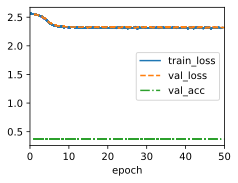

In [50]:
train_data = PIIData(features=feature_tensor, targets=target_tensor, batch_size=32)
model1 = BiLSTMModel(vocab_size=44400,embedding_dim=25, num_hiddens=64, num_outputs=13, lr=0.05)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model1, train_data)

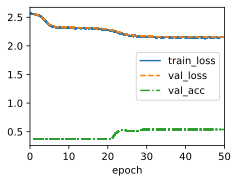

In [62]:
train_data = PIIData(features=feature_tensor, targets=target_tensor, batch_size=32)
model2 = PreTrained_BiLSTMModel(word2vec_model=word2vec_model, num_hiddens=64, num_outputs=13, lr=0.05)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model2, train_data)

# Evaluating the model

## 1. Defining feature and target tensors for training

In [51]:
test_features = test_set['encoded_tokens'].values
test_feature_tensor = torch.tensor(test_features, dtype=torch.int64)
test_feature_tensor = test_feature_tensor.view(-1, 1)
test_feature_tensor

tensor([[38106],
        [16073],
        [   41],
        ...,
        [    4],
        [    1],
        [    4]])

In [52]:
true_labels = test_set['encoded_labels'].values
true_label_tesnor = torch.tensor(true_labels, dtype=torch.int64)
true_label_tesnor

tensor([12,  5, 12,  ..., 12, 12, 12])

In [64]:
test_data = PIIData(features=test_feature_tensor, targets=true_label_tesnor, batch_size=len(test_feature_tensor), train=False)
test_dataloader = test_data.get_test_dataloader()
test_dataloader

<generator object get_test_dataloader at 0x7ff136e65270>

## 2. Making predictions over test data

In [54]:
# Set the model to evaluation mode
model1.eval()

# Initialize variables to store predictions and true labels
all_predictions = []
all_true_labels = []

# Iterate over the test dataset in batches
for batch in test_dataloader:
    # Extract inputs and true labels from the batch
    inputs, labels = batch
    print('hm...')
    print("Batch Size:", inputs.size(0))
    print("Input Shape:", inputs.shape)
    print("Label Shape:", labels.shape)  
    
    # Forward pass: compute predictions
    with torch.no_grad():
        predictions = model1(inputs)
    
    # Store predictions and true labels
    all_predictions.append(predictions)
    all_true_labels.append(labels)

# Concatenate predictions and true labels across batches
all_predictions = torch.cat(all_predictions)
all_true_labels = torch.cat(all_true_labels)

# Compute accuracy using the provided accuracy function
test_accuracy = model1.accuracy(all_predictions, all_true_labels)

# Print or log the test accuracy
print("Test Accuracy:", test_accuracy.item())


hm...
Batch Size: 1468
Input Shape: torch.Size([1468, 1])
Label Shape: torch.Size([1468])
Test Accuracy: 0.3739781975746155


In [65]:
# Set the model to evaluation mode
model2.eval()

# Initialize variables to store predictions and true labels
all_predictions = []
all_true_labels = []

# Iterate over the test dataset in batches
for batch in test_dataloader:
    # Extract inputs and true labels from the batch
    inputs, labels = batch
    print('hm...')
    print("Batch Size:", inputs.size(0))
    print("Input Shape:", inputs.shape)
    print("Label Shape:", labels.shape)  
    
    # Forward pass: compute predictions
    with torch.no_grad():
        predictions = model2(inputs)
    
    # Store predictions and true labels
    all_predictions.append(predictions)
    all_true_labels.append(labels)

# Concatenate predictions and true labels across batches
all_predictions = torch.cat(all_predictions)
all_true_labels = torch.cat(all_true_labels)

# Compute accuracy using the provided accuracy function
test_accuracy = model2.accuracy(all_predictions, all_true_labels)

# Print or log the test accuracy
print("Test Accuracy:", test_accuracy.item())

hm...
Batch Size: 1468
Input Shape: torch.Size([1468, 1])
Label Shape: torch.Size([1468])
Test Accuracy: 0.555858314037323


In [56]:
def extract_examples(test_data, num_examples):
    """Extract a specified number of examples from test data"""
    examples = []
    for batch_idx, (X_test, y_test) in enumerate(test_data):
        for i in range(1, min(num_examples, len(X_test))):
            examples.append((X_test[i], y_test[i]))
        if len(examples) >= num_examples:
            break
    return examples

In [67]:
test_data1 = PIIData(features=test_feature_tensor, targets=true_label_tesnor, batch_size=len(test_feature_tensor), train=False)
examples1 = test_data1.get_test_dataloader()
test_examples1 = extract_examples(examples1, 1024)
test_examples1

[(tensor([16073]), tensor(5)),
 (tensor([41]), tensor(12)),
 (tensor([25556]), tensor(2)),
 (tensor([6559]), tensor(8)),
 (tensor([16535]), tensor(2)),
 (tensor([16612]), tensor(8)),
 (tensor([31007]), tensor(4)),
 (tensor([15043]), tensor(2)),
 (tensor([33452]), tensor(2)),
 (tensor([14736]), tensor(2)),
 (tensor([7]), tensor(12)),
 (tensor([38]), tensor(12)),
 (tensor([26]), tensor(9)),
 (tensor([3385]), tensor(12)),
 (tensor([20138]), tensor(0)),
 (tensor([6]), tensor(12)),
 (tensor([62]), tensor(12)),
 (tensor([25309]), tensor(0)),
 (tensor([26]), tensor(9)),
 (tensor([169]), tensor(12)),
 (tensor([10528]), tensor(8)),
 (tensor([58]), tensor(3)),
 (tensor([1]), tensor(12)),
 (tensor([13529]), tensor(10)),
 (tensor([8]), tensor(12)),
 (tensor([27296]), tensor(6)),
 (tensor([69]), tensor(12)),
 (tensor([31094]), tensor(4)),
 (tensor([10435]), tensor(2)),
 (tensor([554]), tensor(12)),
 (tensor([29]), tensor(12)),
 (tensor([32476]), tensor(1)),
 (tensor([6]), tensor(12)),
 (tensor([168

In [ ]:
# (tensor([11538]), tensor(2)),
 # (tensor([16424]), tensor(8))

In [68]:
tensor1 = torch.tensor([16535])
tensor2 = torch.tensor([16612])

tensor1, tensor2

(tensor([16535]), tensor([16612]))

In [69]:
model2.eval()  # Set the model to evaluation mode

# Create a mini-batch containing the two tensors
inputs = torch.stack([tensor1, tensor2], dim=0)  # Assuming tensor1 and tensor2 are your tensors

# Forward pass: compute predictions
with torch.no_grad():
    predictions = model2(inputs)

# Assuming predictions is the output from your model
print("Predictions:", predictions)

max_indices = torch.argmax(predictions, dim=1)

# Display indices
print("Max indices:", max_indices)

Predictions: tensor([[7.4373e-04, 9.0240e-04, 9.8615e-01, 6.4519e-04, 7.0711e-04, 8.3515e-04,
         7.8851e-04, 6.5180e-04, 5.7533e-03, 7.5419e-04, 7.6175e-04, 6.5943e-04,
         6.4316e-04],
        [4.0513e-04, 5.0006e-04, 9.9217e-01, 3.5299e-04, 3.8151e-04, 4.6175e-04,
         4.4075e-04, 3.6585e-04, 3.5434e-03, 4.1483e-04, 4.2642e-04, 3.6930e-04,
         1.7097e-04]])
Max indices: tensor([2, 2])


In [ ]:
# output format for predictiions?
# convert prediction indices to bio labels
# use kaggle test set, don't split train set
